In [2]:
import math
import random

import gym
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.multiprocessing as mp
from torch.distributions import Categorical

In [3]:
from IPython.display import clear_output
import matplotlib.pyplot as plt

In [4]:
num_envs = 16
env_name = "CartPole-v0"

envs = [gym.make(env_name) for _ in range(num_envs)]
test = gym.make(env_name)

In [5]:
device = torch.device("cuda" if torch.cuda.is_available else "cpu")
print(device)

cuda


In [6]:
class Actor(nn.Module):
    def __init__(self, input_shape, n_actions):
        super(Actor, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_shape, 256),            
            nn.ReLU(),
            nn.Linear(256, n_actions),
            nn.Softmax(dim=-1)
        )

    def forward(self, x):
        probs = self.net(x)
        dist = Categorical(probs)
        return dist

In [7]:
class Critic(nn.Module):
    def __init__(self, input_shape):
        super(Critic, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_shape, 256),            
            nn.ReLU(),
            nn.Linear(256, 1)
        )
    
    def forward(self, x):
        value = self.net(x)
        return value

In [22]:
def plot(frame_idx, rewards):
    clear_output(True)
    plt.figure(figsize=(20,5))
    plt.subplot(131)
    plt.title(f"Frame {frame_idx} reward :{rewards[-1]}")
    plt.plot(rewards)
    plt.show()

def test_env(vis=False):
    state = test.reset()
    done = False
    total_reward = 0
    while not done:
        state = torch.tensor(state, dtype=torch.float).unsqueeze(0).to(device)
        dist = actor(state)        
        next_state, reward, done, _ = test.step(dist.sample().cpu().numpy()[0])
        state = next_state
        if vis:
            test.render(mode="rgb_array")
        total_reward += reward
    return total_reward

In [8]:
def compute_returns(next_values, rewards, masks, gamma=0.99):
    R = next_values
    returns = []
    for step in reversed(range(len(rewards))):
        R = rewards[step] + gamma * R * masks[step]
        returns.insert(0, R)
    return returns

In [9]:
input_shape = envs[0].observation_space.shape[0]
n_actions = envs[0].action_space.n

num_steps = 5
actor = Actor(input_shape, n_actions).to(device)
critic = Critic(input_shape).to(device)

actor_optimizer = optim.Adam(actor.parameters(), lr=1e-4)
critic_optimizer = optim.Adam(critic.parameters(), lr=1e-3)

In [10]:
max_frames = 50000
frame_idx = 0
test_rewards = []

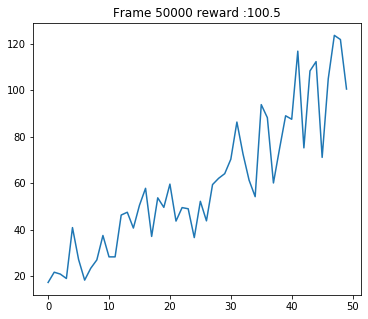

In [13]:
states = np.concatenate([[envs[idx].reset()] for idx in range(num_envs)])
while frame_idx < max_frames:
    log_prob_list = []
    value_list = []
    reward_list = []
    mask_list = []
    entropy_list = []
    next_states_list = []
    entropy = 0
    
    for _ in range(num_steps):
        states_t = torch.tensor(states, dtype=torch.float).to(device)
        dists = actor(states_t)
        values = critic(states_t)

        actions = dists.sample()
        actions_np = actions.cpu().numpy()
        next_states, rewards, done, _ = zip(*[envs[idx].step(actions_np[idx]) for idx in range(num_envs)])
        next_states = np.asarray(next_states)
        rewards = np.asarray(rewards)
        done = np.asarray(done)

        log_prob = dists.log_prob(actions)
        entropy += dists.entropy().mean()

        log_prob_list.append(log_prob)
        value_list.append(values)

        rewards_t = torch.tensor(rewards, dtype=torch.float).unsqueeze(-1).to(device)
        reward_list.append(rewards_t)

        mask_t = torch.tensor(1-done, dtype= torch.float).unsqueeze(-1).to(device)
        mask_list.append(mask_t)

        '''
        if done:
            next_states = env.reset()
        '''
        for idx in range(num_envs):
            if done[idx] == True:
                next_states[idx] = envs[idx].reset()
                 
        states = next_states
        frame_idx += 1

        if frame_idx % 1000 == 0:
            test_rewards.append(np.mean([test_env() for _ in range(10)]))
            plot(frame_idx, test_rewards)

         
    next_states_t = torch.tensor(next_states, dtype=torch.float).to(device)    
    next_value = critic(next_states_t)    
    returns = compute_returns(next_value, reward_list, mask_list)
    '''
        >>> s
        tensor([1., 2., 3.])
        >>> a = []
        >>> a.append(s)
        >>> a
        [tensor([1., 2., 3.])]
        >>> a.append(s)
        >>> a
        [tensor([1., 2., 3.]), tensor([1., 2., 3.])]
        >>> torch.cat(a)
        tensor([1., 2., 3., 1., 2., 3.])
        >>> torch.stack(a)
        tensor([[1., 2., 3.],
                [1., 2., 3.]])
    '''
    
    log_prob_t = torch.cat(log_prob_list)
    returns_t = torch.cat(returns)
    values = torch.cat(value_list)    
    
    advantage = returns_t - values
    assert returns_t.shape == values.shape, f"Different shape. returns_t : {returns_t.shape}, values : {values.shape}"

    actor_loss = -(log_prob_t * advantage.detach()).mean() - 0.001 * entropy
    critic_loss = nn.MSELoss()(returns_t, values)

    actor_optimizer.zero_grad()
    critic_optimizer.zero_grad()

    actor_loss.backward()
    critic_loss.backward()

    actor_optimizer.step()
    critic_optimizer.step()

In [26]:
test_env(vis=True)

200.0